### S15. Aprenentatge No Supervisat - Agrupació

In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, RobustScaler

##### Load the database

In [91]:
#Loading the dataset
df=pd.read_csv('delayedflights.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [92]:
#group the least busy airlines into OTH(er)

def airlines(n):
    if (n =='F9' or n =='HA' or n =='AQ'):
        n="OTH"
    return n
df['UniqueCarrier'] = df['UniqueCarrier'].apply(airlines)

In [93]:
#Make list of Airports with less than an average of 5 flights a day
values = df['Origin'].value_counts(dropna=False).keys().tolist()
counts = df['Origin'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
small=[]
for key in value_dict:
    if value_dict[key] < 350:
        small.append(key)

In [94]:
# Group Airports with little flights a week into 'Others'
def airport(m):
    if m in small:
        m='Other'
    elif (m =='CYS' or m =='OGD'):
        m='Other'
    return m

df['Origin'] = df['Origin'].apply(airport)
df['Dest'] = df['Dest'].apply(airport)

In [95]:
# Delete both ArrTime and ArrDelay (target column) null values because they are most likely linked to cancellations and diverions
df.dropna(subset=['ArrTime','UniqueCarrier','ArrDelay'], inplace=True)

# Bin departures and arrivals delays in 15 mins intervals

def bin15(xx):
    xx=(int(xx/15))*15
    return xx

df['DepDelay'] = df['DepDelay'].apply(bin15)
df['ArrDelay'] = df['ArrDelay'].apply(bin15)

In [96]:
#select the relevant attributes for an objective prediction before flying.  
df=df[['Month', 'DayOfWeek', 'DepTime','ArrTime', 'UniqueCarrier', 'CRSElapsedTime', 
       'Origin', 'Dest','DepDelay','CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','ArrDelay']]
df = df.sample(frac =.05).reset_index().drop(['index'], axis=1)
df.head(3)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,8,6,1749.0,1957.0,CO,239.0,EWR,IAH,20.0,NaN,NaN,NaN,NaN,NaN,-31.0
1,5,2,49.0,857.0,B6,316.0,ONT,JFK,50.0,0.0,0.0,0.0,0.0,42.0,42.0
2,2,7,1645.0,1704.0,NW,70.0,DTW,MDW,84.0,84.0,0.0,9.0,0.0,0.0,93.0


In [97]:
df.isnull().sum()

Month                    0
DayOfWeek                0
DepTime                  0
ArrTime                  0
UniqueCarrier            0
CRSElapsedTime           0
Origin                   0
Dest                     0
DepDelay                 0
CarrierDelay         34325
WeatherDelay         34325
NASDelay             34325
SecurityDelay        34325
LateAircraftDelay    34325
ArrDelay                 0
dtype: int64

In [98]:
# Convert selected columns nulls to 0
cols= ['CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df[cols]=df[cols].fillna(0)

In [99]:
#Simplifying the Arrival and Departure time into time frames (in this case, numericals representing morning, afternon, evenening and night)
df['DepTime'] = pd.cut(df.DepTime, bins=4,labels=[1,0.25,0.5,0.75])
df['ArrTime'] = pd.cut(df.ArrTime, bins=4,labels=[1,0.25,0.5,0.75])

In [100]:
# in order to control some of the outliers, all delays higher than 10 hours will be reduced to this amount

cols= ['DepDelay','ArrDelay','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']

def bigdelay(zz):
    if zz > 600:
        return 600
    else:
        return zz

for co in cols:
    df[co] = df[co].apply(bigdelay)

In [103]:
#bin Delay related columns by 15 mins and also preprocess with QuantileTransformer

def bin15(xx):
    xx=(int(xx/15))*15
    return xx

scaler = QuantileTransformer()
for co in cols:
    df[co] = df[co].apply(bin15)
    df[[co]] = scaler.fit_transform(df[[co]])

In [105]:
df.head(10)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,8,6,0.50,0.75,CO,239.0,EWR,IAH,0.443944,0.000000,0.0,0.000000,0.0,0.000000,0.000501
1,5,2,1.00,0.25,B6,316.0,ONT,JFK,0.741742,0.000000,0.0,0.000000,0.0,0.850350,0.625125
2,2,7,0.50,0.50,NW,70.0,DTW,MDW,0.858859,0.964464,0.0,0.000000,0.0,0.000000,0.883884
3,7,5,0.25,0.50,MQ,60.0,ORD,IND,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.183183
4,8,3,0.75,0.75,AA,175.0,DFW,MIA,0.636136,0.834334,0.0,0.000000,0.0,0.770270,0.728729
5,2,7,0.25,0.50,DL,210.0,SLC,CVG,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.183183
6,2,7,0.50,0.50,WN,85.0,OAK,LAS,0.810811,0.000000,0.0,0.960460,0.0,0.000000,0.798298
7,1,3,0.50,0.50,AA,160.0,LGA,ORD,0.000000,0.000000,0.0,0.873373,0.0,0.000000,0.458959
8,9,6,0.25,0.50,UA,142.0,DEN,SNA,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.183183
9,6,5,0.75,0.75,WN,75.0,SAN,LAS,0.858859,0.000000,0.0,0.000000,0.0,0.895896,0.728729


In [106]:
##### Frequency Encoding columna Month, DayOfWeek i UniqueCarrier
freq=['Month','DayOfWeek','UniqueCarrier','Origin','Dest']
for xx in freq:
    fe=df.groupby(xx).size()/len(df)
    df.loc[:,xx]=df[xx].map(fe)

In [108]:
#Apply RobustScaler to CRSElapsedTime and Distance

scaler1 = RobustScaler()
df[['CRSElapsedTime']] = scaler1.fit_transform(df[['CRSElapsedTime']])

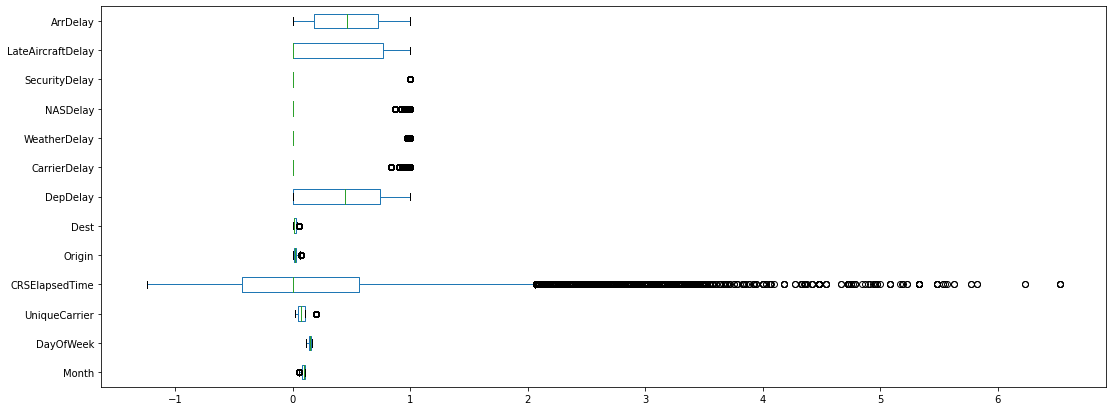

In [109]:
df.plot(kind='box',figsize=(18,7),vert=False)

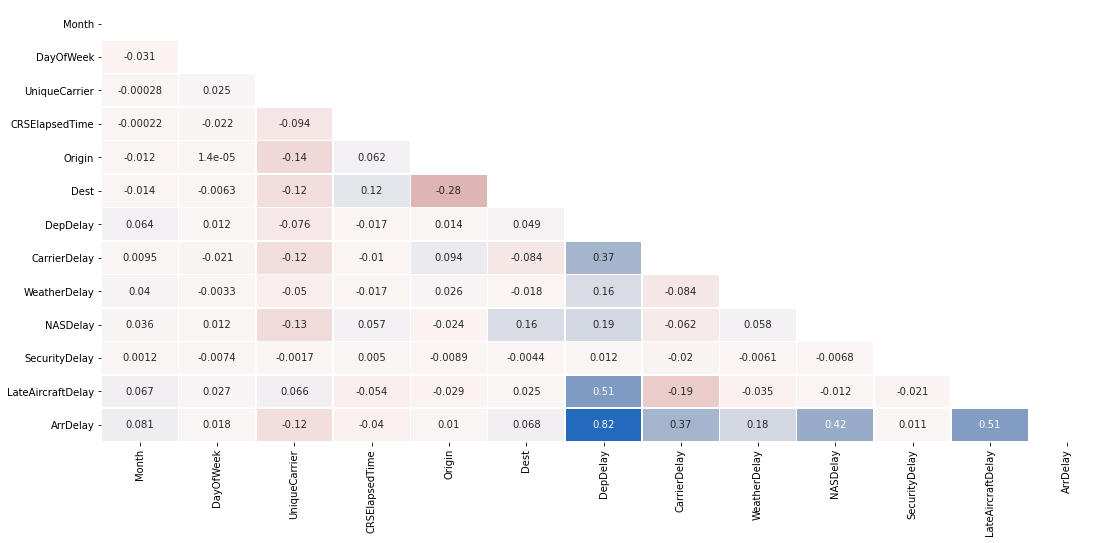

In [110]:
# Correlation Heatmap 
corr = df.corr()
cmap = sns.light_palette("#0c2a70", as_cmap=True)
mask = np.triu(corr)
plt.figure(figsize=(18,8))
sns.heatmap(corr, cmap='vlag_r', annot=True, linewidths=0.5, center=0, cbar=False, xticklabels=True,
           mask=mask)

In [111]:
df.to_csv('delays_self1.csv')